# ER / NR discrimination test

In [1]:
!wget -nc https://raw.githubusercontent.com/FlamTeam/flamedisx-notebooks/master/_if_on_colab_setup_flamedisx.ipynb
%run _if_on_colab_setup_flamedisx.ipynb

File ‘_if_on_colab_setup_flamedisx.ipynb’ already there; not retrieving.

TensorFlow 2.x selected.
Flamedisx is installed :-)


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from multihist import Hist1d, Histdd
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats, interpolate
import pickle

import flamedisx
import flamedisx as fd
from flamedisx.x1t_sr0 import SR0WIMPSource, SR0ERSource, SR0NRSource

have_gpu = tf.test.is_gpu_available()
tf.__version__, tfp.__version__, have_gpu, tf.executing_eagerly()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


('2.1.0-rc1', '0.7.0', True, True)

## Initialization

In [0]:
class LowMassWIMPSource(SR0WIMPSource):
    mw = 30  # GeV
    n_in = 2  # single WIMP spectrum (no modulation)
    # Only for 10 GeV WIMP
    # es = np.geomspace(0.7, 10, 100) # [keV]
    
class LowEnergyERSource(SR0ERSource):
    def _single_spectrum(self):
        """Return (energies in keV, rate at these energies),
        """
        return (tf.dtypes.cast(
                    tf.linspace(0., 5., 1000),  # 10 keV for 1 TeV WIMP
                    dtype=fd.float_type()),
                tf.ones(1000, dtype=fd.float_type()))
    
def annotate_cs(d):
    d['cs1'] = (0.142 / (1 + 0.219)) * d['s1'] / (
        d['photon_detection_eff'] * d['photon_gain_mean'])
    d['cs2'] = (11.4 / (1 - 0.63) / 0.96) * d['s2'] / (
        d['electron_detection_eff'] * d['electron_gain_mean'])

In [0]:
dsets = dict(
    er=dict(source_class=LowEnergyERSource),
    nr=dict(source_class=LowMassWIMPSource))

for k, v in dsets.items():
    dsets[k]['source'] = v['source_class'](batch_size=300 if have_gpu else 10, 
                                           # May want to increase this for real computation...
                                           max_sigma=4)

In [0]:
## Compute rate histograms

100%|██████████| 100/100 [02:17<00:00,  1.37s/it]


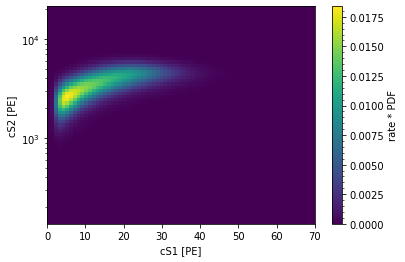

100%|██████████| 40/40 [00:45<00:00,  1.14s/it]


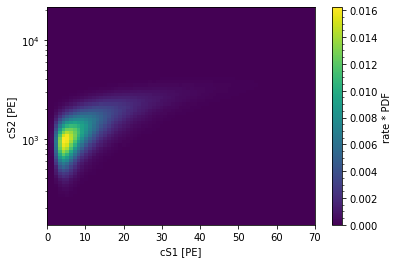

In [6]:
def std_axes():
    plt.yscale('log')
    plt.xlabel("cS1 [PE]")
    plt.ylabel("cS2 [PE]")

for dname, q in dsets.items():
    q['mh'] = mh = Histdd(bins=(
        np.linspace(0, 70, 71 + 1),
        np.geomspace(10**1.7 / (1 - 0.63),
                     10**3.9 / (1 - 0.63), 
                     70)
    ))
    
    n_batches = 100 if dname == 'er' else 40
    trials_per_batch = int(1e5)   # Set to 1e6 if you are really going for it

    for _ in tqdm(range(n_batches)):
        d = q['source'].simulate(trials_per_batch)
        annotate_cs(d)
        mh.add(d['cs1'], d['cs2'])
    
    # Convert to PDF
    mh /= mh.bin_volumes() * trials_per_batch * n_batches

    # Multiply by total expected event rate
    # (from the source, i.e. before correcting for efficiencies)
    mh *= q['source'].mu_before_efficiencies()
    q['mh'] = mh

    mh.plot(cblabel='rate * PDF')
    std_axes()
    plt.show()

  * Make sure none of the models are 'cut off' in cS1 / cS2, since cS1 and cS2 cut acceptances are not currently accounted for in our likelihood (unlike S1 or S2 cuts). This is not a limitation of flamedisx: the correction value is known for each event since the correction depends only on observables, so ultimately a cS1 cut is just a space-dependent S1 cut (which flamedisx fully supports).
  * The ROC curves will depend on the extent of the ER spectrum. If you include more high-energy ER events that can be discriminated anyway, the ER leakage in any likelihood will go down. The key figure of merit we are trying to derive here, the decrease in ER leakage at ~50 % NR acceptance when switching to the full likelihood, should be unaffected by this.

## Histogram-based discrimination

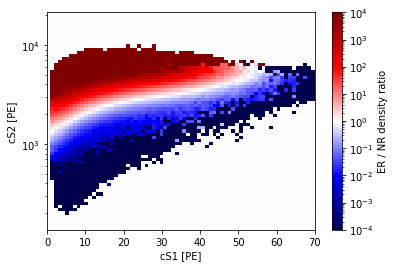

In [7]:
ratio = (dsets['er']['mh'] + 1e-20)/(dsets['nr']['mh'] + 1e-20)
indexes = np.argsort(ratio.histogram.ravel())

ratio.plot(log_scale=True, cmap=plt.cm.seismic, 
           vmin=1e-4, vmax=1e4, cblabel='ER / NR density ratio')
std_axes()

Text(0, 0.5, 'NR acceptance')

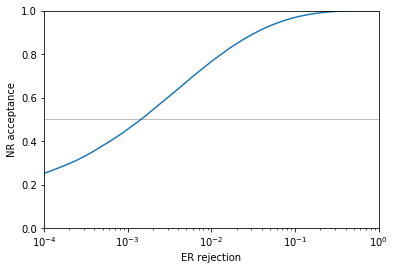

In [8]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
roc_from_histogram = (np.cumsum(dsets['er']['mh'].histogram.ravel()[indexes])/dsets['er']['mh'].n,
                      np.cumsum(dsets['nr']['mh'].histogram.ravel()[indexes])/dsets['nr']['mh'].n)
plt.plot(*roc_from_histogram)
plt.xscale('log')

plt.axhline(0.5, alpha=0.5, c='k', linewidth=0.5)

plt.xlim(1e-4, 1)
plt.ylim(0, 1)
plt.xlabel("ER rejection")
plt.ylabel("NR acceptance")

In [0]:
## Flamedisx-based discrimination

In [0]:
n_trials_events = int(1e5) if have_gpu else int(1e4)    # Or use 1e6 if you're very serious

In [11]:
for dname, q in dsets.items():
    q['data'] = d = q['source'].simulate(n_trials_events)
    annotate_cs(d)
    
    # Ensure cs1 and cs2 are in range of the histogram
    # to avoid extrapolation in multihist's lookup.
    # NB: we are assuming both histograms have the same binning here!
    bes = q['mh'].bin_edges
    mask = (
        (bes[0][0] <= d['cs1']) & (d['cs1'] < bes[0][-1]) &
        (bes[1][0] <= d['cs2']) & (d['cs2'] < bes[1][-1]))
    print(f"{dname}: Throwing out {100 * (~mask).sum() / len(d):.2f}% of events")
    q['data'] = d = d[mask].copy()
    
    for _dn in dsets.keys():
        w = dsets[_dn]
        w['source'].set_data(d.copy())
        d['l_full_' + _dn] = w['source'].batched_differential_rate()
        d['l_mh_' + _dn] = w['mh'].lookup(d['cs1'], d['cs2'])
        
    for lt in ('mh', 'full'):
        d['lr_' + lt] = d['l_%s_er' % lt] / d['l_%s_nr' % lt]

er: Throwing out 0.00% of events


100%|██████████| 244/244 [00:30<00:00,  8.99it/s]


nr: Throwing out 0.04% of events


100%|██████████| 172/172 [00:19<00:00,  9.15it/s]


# Results

In [0]:
# Load earlier results: 
#with open('discstudy_22oct_elife452.pkl', mode='rb') as f:
#    dsets = pickle.load(f)
#     for k, v in q.items():
#         dsets[k].update(**v)

## Compare differential rates

Compare differential rates. There will be an offset because (cS1, cS2) and (S1, S2) have different ranges/means -- so the rates are differential with respect to different coordinates.

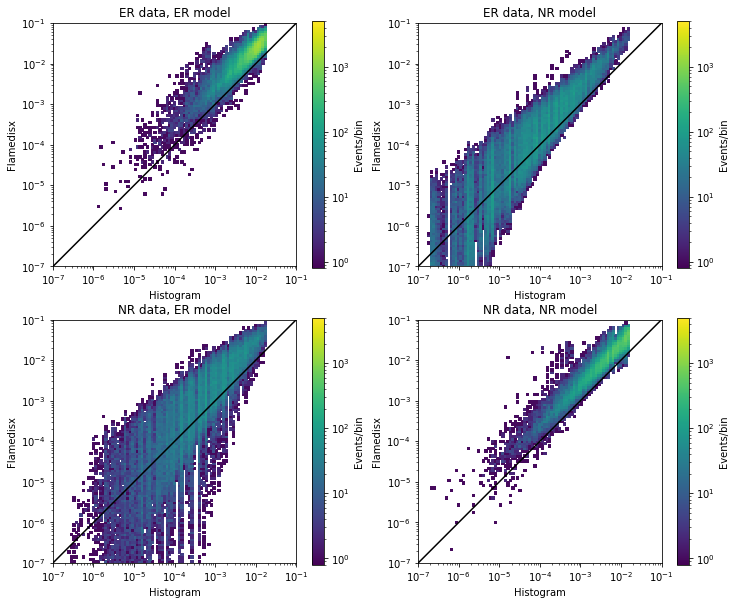

In [13]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))

for dn_i, dn in enumerate(dsets):
    for lh_i, lh_dn in enumerate(dsets):
        ax = axes[dn_i, lh_i]
        plt.sca(ax)
        
        q = dsets[dn]['data']
        y, x = q['l_full_' + lh_dn], q['l_mh_' + lh_dn]

        Histdd(x, y,
               bins=(np.geomspace(1e-7, 1e-1, 100),
                     np.geomspace(1e-7, 1e-1, 100))).plot(
            log_scale=True, cblabel='Events/bin',
            vmin=0.8, vmax=n_trials_events * 0.05)

        plt.plot([1e-7, 1e-1], [1e-7, 1e-1], 'k-')
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("Histogram")
        plt.ylabel("Flamedisx")
        plt.ylim(1e-7, 1e-1)
        plt.xlim(1e-7, 1e-1)
        plt.title(f"{dn.upper()} data, {lh_dn.upper()} model")
        plt.gca().set_aspect(1)
plt.show()

In [0]:
# # Zoom-in on the low-energy NR data
# d = dsets['nr']['data']
# dsets['er']['mh'].plot(log_scale=True, vmin=1e-6, vmax=1e-1, cmap=plt.cm.Blues, cblabel="Diffrate hist")
# plt.scatter(d['cs1'], d['cs2'], c=d['l_full_er'], s=0.1, 
#             vmax=1e-1, vmin=1e-6, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.Reds)
# plt.colorbar(label='Diffrate Flamedisx')
# plt.xlim(0, 10)
# plt.xlabel("cS1 [PE]")
# plt.ylim(0, 3e3)
# plt.ylabel("cS2 [PE]")

## Compare event-by-event discrimination

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


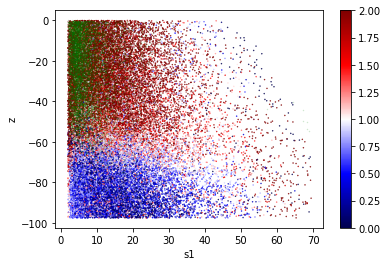

In [15]:
d_er = dsets['er']['data']
d_nr = dsets['nr']['data']

for d, alt, cmap in [#(d_er, d_nr, plt.cm.viridis),
                     (d_nr, d_er, plt.cm.magma)
                    ]:
    # For each event in d, find what fraction of the alt data is more NR-like than it
    # (under both likelihoods)
    f_above = {
        lt: np.searchsorted(np.sort(alt[f'lr_{lt}'].values), 
                            d[f'lr_{lt}'].values).astype(np.float) / len(alt)
        for lt in ('mh', 'full')}

    # Get ratio. 
    #   0 = mh sees the event as more NR-like than any of the alt data
    #   > 1: mh is worse at discriminating, < 1 mh is better at discriminating
    ratio = f_above['mh'] / f_above['full']
    mask = np.isfinite(ratio)
    
    xkey, ykey = 's1', 'z'
    
    plt.scatter(d[xkey][mask], d[ykey][mask], c=ratio[mask], #cmap=cmap,
                vmin=0, vmax=2, cmap=plt.cm.seismic,
                s=0.2,)
    plt.colorbar()
    plt.scatter(d[xkey][~mask], d[ykey][~mask], c='g',
                s=0.2, alpha=0.2)
    
    plt.xlabel(xkey)
    #plt.ylim(0, 700)
    plt.ylabel(ykey)
    plt.show()

For these NR events, red events have a more NR-like ER/NR likelihood ratio in flamedisx, and blue ones in the histogram likelihood. For green events the ratio of the two likelihood ratios is not a finite number.

In [0]:
# # Saving data for later:
# dsets_data = dict()
# for dn in ['er', 'nr']:
#     dsets_data[dn] = dict()
#     for k, v in dsets[dn].items():
#         if k in ['source', 'source_class']:
#             continue
#         print(dn, k, type(v))
#         dsets_data[dn][k] = v
#
# with open('discstudy_23oct_elife452_10GeV_modulation.pkl', mode='wb') as f:
#     pickle.dump(dsets_data, f)

Log likelihood ratio histograms for ER and NR data under both likelihoods below. Note many events are at the final edges for the histogram, due to clipping.

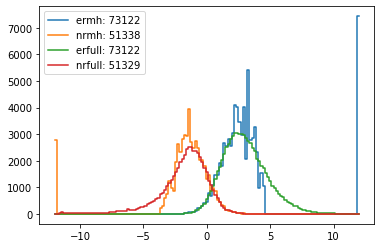

In [17]:
plt.figure()
plt.gcf().patch.set_facecolor('white')
for lt, color in [['mh', 'b'], ['full', 'g']]:
    hists = dict()
    cis = dict()
    for dname, q in dsets.items():
        clip_exp = 12
        hists[dname] = Hist1d(
            np.log10(q['data']['lr_' + lt].clip(10**-clip_exp, 10**clip_exp).values.astype('float')),
            bins=np.linspace(-12, 12, 140))
        hists[dname].plot(label=f"{dname}{lt}: {hists[dname].n}")
#plt.yscale('log')
plt.legend()
plt.show()

## ROC Curves

In [0]:
def binom_interval(success, total, conf_level=0.95):
    """Confidence interval on binomial - using Jeffreys interval
    Code stolen from https://gist.github.com/paulgb/6627336
    Agrees with http://statpages.info/confint.html for binom_interval(1, 10)
    """
    # TODO: special case for success = 0 or = total? see wikipedia
    quantile = (1 - conf_level) / 2.
    lower = stats.beta.ppf(quantile, success, total - success + 1)
    upper = stats.beta.ppf(1 - quantile, success + 1, total - success)
    
    # If something went wrong with a limit calculation, report the trivial limit
    lower[np.isnan(lower)] = 0
    upper[np.isnan(upper)] = 1
    return lower, upper

In [0]:
def make_roc(dsets):
    results = dict()
#     plt.figure()
#     plt.gcf().patch.set_facecolor('white')
    for lt, color in [['mh', 'b'], ['full', 'g']]:
        hists = dict()
        cis = dict()
        for dname, q in dsets.items():
            hists[dname] = Hist1d(np.log10(q['data']['lr_' + lt].clip(1e-20, 1e20)),
                                bins=np.linspace(-21, 21, 10000))
            
            cis[dname] = binom_interval(
                np.cumsum(hists['er'].histogram),
                hists['er'].n, 
                conf_level=.68)
            
        x = np.cumsum(hists['er'].normalized_histogram)
        xlow, xhigh = cis['er'][0], cis['er'][1]
        y = np.cumsum(hists['nr'].normalized_histogram)
        
        results[lt] = dict(x=x, y=y, cis=cis, xlow=xlow, xhigh=xhigh, hists=hists)
        
        plt.plot(x, y,
                label=dict(mh="Classical (cS1, cS2)", 
                            full="Full (S1, S2, x, y, z, t)")[lt],
                color=color)
        
        print("%s: %0.3g ER bg. at 50%% NR acceptance" % (
            lt, x[np.argmin(np.abs(y - 0.5))]
        ))
        
        plt.fill_betweenx(
            y, cis['er'][0], cis['er'][1],
            color=color, alpha=0.2, linewidth=0, step='mid')

    plt.legend(loc='lower right', frameon=False, fontsize=12)
        
    plt.xscale('log')
    plt.xlabel("ER (flat 0-5 keV) background")
    plt.ylabel(f"{LowMassWIMPSource.mw} GeV/c^2 WIMP acceptance")
    #plt.xlim(1e-4, 1e-1)
    #plt.xlim(0, 1)
    #plt.ylim(0.95, 1)
    plt.tight_layout()
    #plt.savefig('ernr_disc_comp_varelife.png', bbox_inches="tight", dpi=200)
    #plt.show()

    return results

mh: 0.00138 ER bg. at 50% NR acceptance
full: 0.000738 ER bg. at 50% NR acceptance


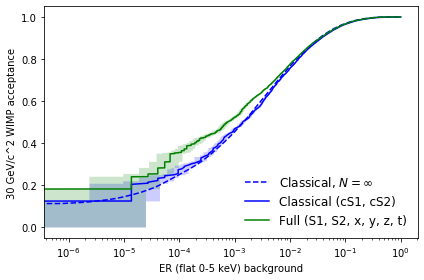

In [20]:
plt.plot(*roc_from_histogram, 
         label='Classical, $N = \infty$', 
         color='b', linestyle='--')
make_roc(dsets);
# plt.xscale('linear')
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)

If you run with low statistics, don't be worried if the curves look quite a bit different. Here's another run at the default settings:

mh: 0.00169 ER bg. at 50% NR acceptance
full: 0.000895 ER bg. at 50% NR acceptance


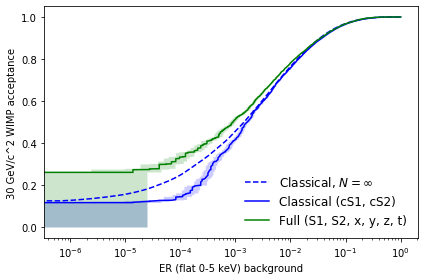

# Comparison between datasets

In [0]:
### Single dataset
mw = 10  # GeV WIMP mass
all_results = dict()
all_results[''] = make_roc(dsets)

In [0]:
### Or load several datasets to compare
basename = 'discstudy_23oct_elife452_10GeV'
#postfix = ['', '_spatial', '_spatial_temp']
postfix = ['', '_modulation']

mw = 10  # GeV WIMP mass
all_results = dict()

for v in postfix:
    with open(basename + v + '.pkl', mode='rb') as f:
        q = pickle.load(f)
        # Make and store ROC curves
        all_results[v] = make_roc(q)

# Sanity check, are all mh rocs the same?
for v in all_results.values():
    plt.plot(v['mh']['x'], v['mh']['y'])
plt.xscale('log')
plt.yscale('log')
plt.title('Ensure these distributions are the same within errors')
plt.show()

In [0]:
plt.figure()
for (k, k2, label, color) in [('', 'mh', 'Classical (cS1, cS2)', None),
                              ('', 'full', 'Full (S1, S2, x, y, z, t)', 'orange'),
                              ('_modulation', 'full', 'Full + modulation', 'green'),
                              #('_spatial', 'full', 'Full + spatial rate', 'green'),
                              #('_spatial_temp', 'full', 'Full + spatial + temporal rate', 'r'),
                              ]:
    q = all_results[k][k2]

    plt.plot(q['x'], q['y'], label=label, color=color)
    
    print("%s: %0.3g ER bg. at 50%% NR acceptance" % (
        label, q['x'][np.argmin(np.abs(q['y'] - 0.5))]
    ))
    
    plt.fill_betweenx(
        q['y'], q['cis']['er'][0], q['cis']['er'][1],
        color=color, alpha=0.2, linewidth=0, step='mid')

plt.legend(loc='lower right', frameon=False, fontsize=12)
    
plt.xscale('log')
plt.xlabel("ER (flat 0-5 keV) background")
plt.ylabel(f"{mw} GeV/c^2 WIMP acceptance")
plt.xlim(1e-6, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('ernr_disc_comp_varelife_10GeV_modulation.png', bbox_inches="tight", dpi=200)
plt.show()

Background reduction plot

In [0]:
results = dict()
results['mh'] = all_results['']['mh']
results['full'] = all_results['']['full']
results['modulation'] = all_results['_modulation']['full']
#results['spatial'] = all_results['_spatial']['full']
#results['time'] = all_results['_spatial_temp']['full']

In [0]:
def reduction_fraction(a, b):
    # background reduction fractions
    ys = (a['']-b[''])/a['']
    
    errs = dict()
    for (v, sign) in [('high', 1), ('low', -1)]:
        # f = a*A - b*B
        # sigmaf = a**2 * sigmaA**2 + b**2 * sigmaB**2   ## no A B correlation
        f = a[''] - b['']
        sf_sq = (a[v] - a[''])**2 + (b[v] - b[''])**2

        # add rel err
        err = (sf_sq/f**2 + (a[v] - a[''])**2/a['']**2) * ys**2
        
        # rel err y
        errs[v] = ys * 100 + sign * (err * 100**2)**0.5
    # mask nans
    errs['high'][np.isnan(errs['high'])] = 100.
    errs['low'][np.isnan(errs['low'])] = 0.
    return ys, errs

In [0]:
f, axes = plt.subplots(2, 1, 
                       figsize=(5, 5), 
                       gridspec_kw = {'height_ratios': [2, 1]},
                       sharex=True)
plt.gcf().patch.set_facecolor('white')

xscale = 100

for lt, color in [['mh', None],
                  ['full', 'orange'],
                  ['modulation', 'green'],
                  #['spatial', 'green'],
                  #['time', 'red'],
                  ]:
    q = results[lt]
    
    plt.sca(axes[0])
    plt.plot(q['y'] * xscale, q['x'],
             label=dict(mh="Classical (cS1, cS2)", 
                        full="Full (S1, S2, x, y, z, t)",
                        spatial="Full + spatial rate",
                        time="Full + spatial + temporal rate",
                        modulation="Full + modulation",
                        )[lt],
             color=color)
    plt.fill_between(
        q['y'] * xscale, q['xlow'], q['xhigh'],
        color=color, alpha=0.2, lw=0)
    
def itp(x, xp, yp):
    return interpolate.interp1d(xp, yp, 
                                bounds_error=False, fill_value=(0,1))(x)
    
plt.sca(axes[1])
pts = np.linspace(0, 1, 1000)
r = {
    lt: {
        q: itp(pts, results[lt]['y'], results[lt]['x' + q])
          for q in ['', 'low', 'high']}
    for lt in results.keys()
}

for (bgf, label, color) in [('full', 'Classical vs Full', 'k'),
                            ('modulation', 'Classical vs Full + modulation', 'g'),
                            #('spatial', 'Classical vs Full + spatial', 'g'),
                            #('time', 'Classical vs Full + spatial + time', 'r'),
                            ]:
    ys, errs = reduction_fraction(r['mh'], r[bgf])

    plt.plot(pts * xscale, 
             100 * ys, c=color, label=label)

    plt.fill_between(pts * xscale,
                     errs['low'],
                     errs['high'], color=color, alpha=0.2, lw=0,
                     )

plt.legend(frameon=False)
plt.ylabel("Bg. reduction (%)")
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.xlabel("%d GeV/c^2 WIMP acceptance (%%)" % mw)

    
plt.sca(axes[0])
plt.yscale('log')
plt.ylim(1.1e-6, 1)
plt.legend(loc='upper left', frameon=False)
plt.ylabel("ER (1-5 keV) bg. fraction")

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('ernr_disc_comp_10GeV_modulation.png', bbox_inches="tight", dpi=200)